In [11]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Load the dataset
data = pd.read_csv('Crimes Dataset.csv')


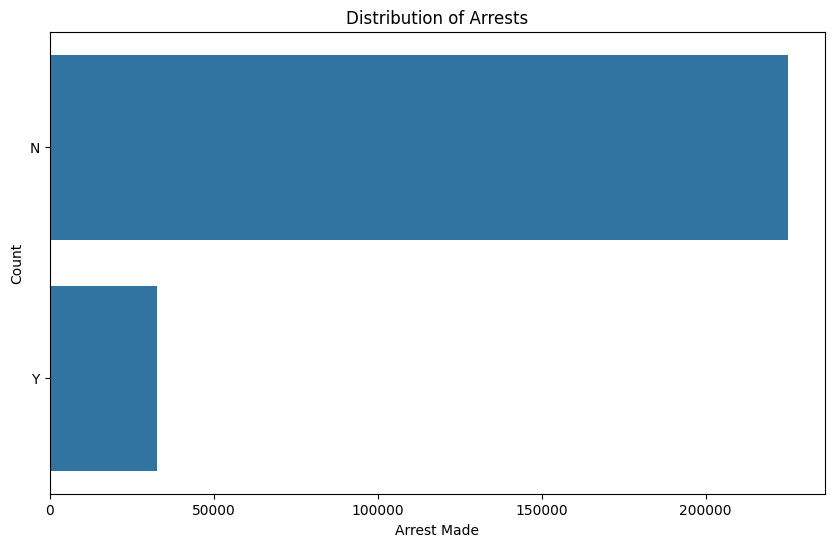

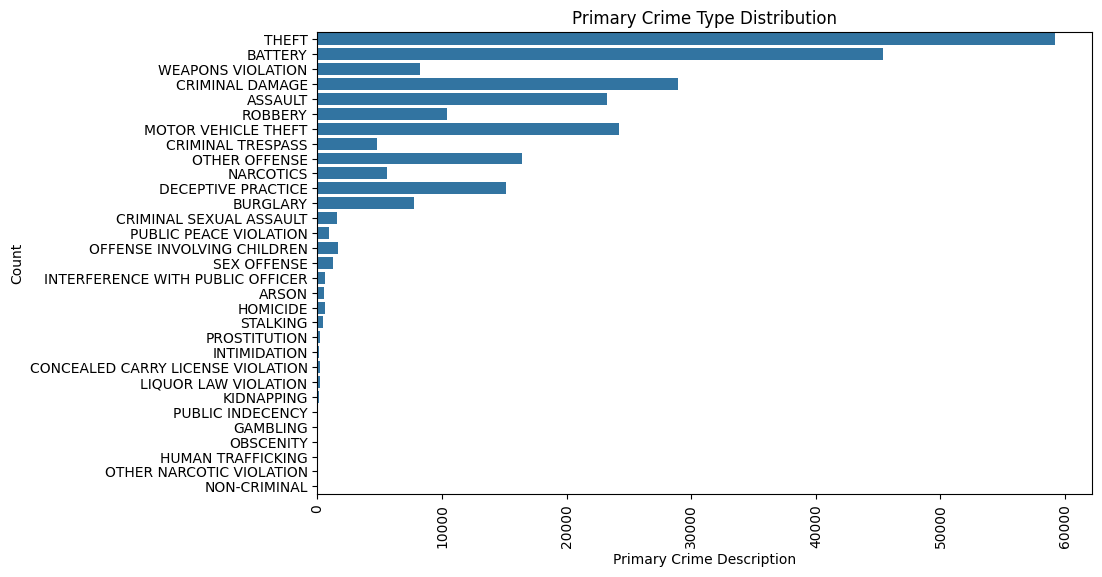

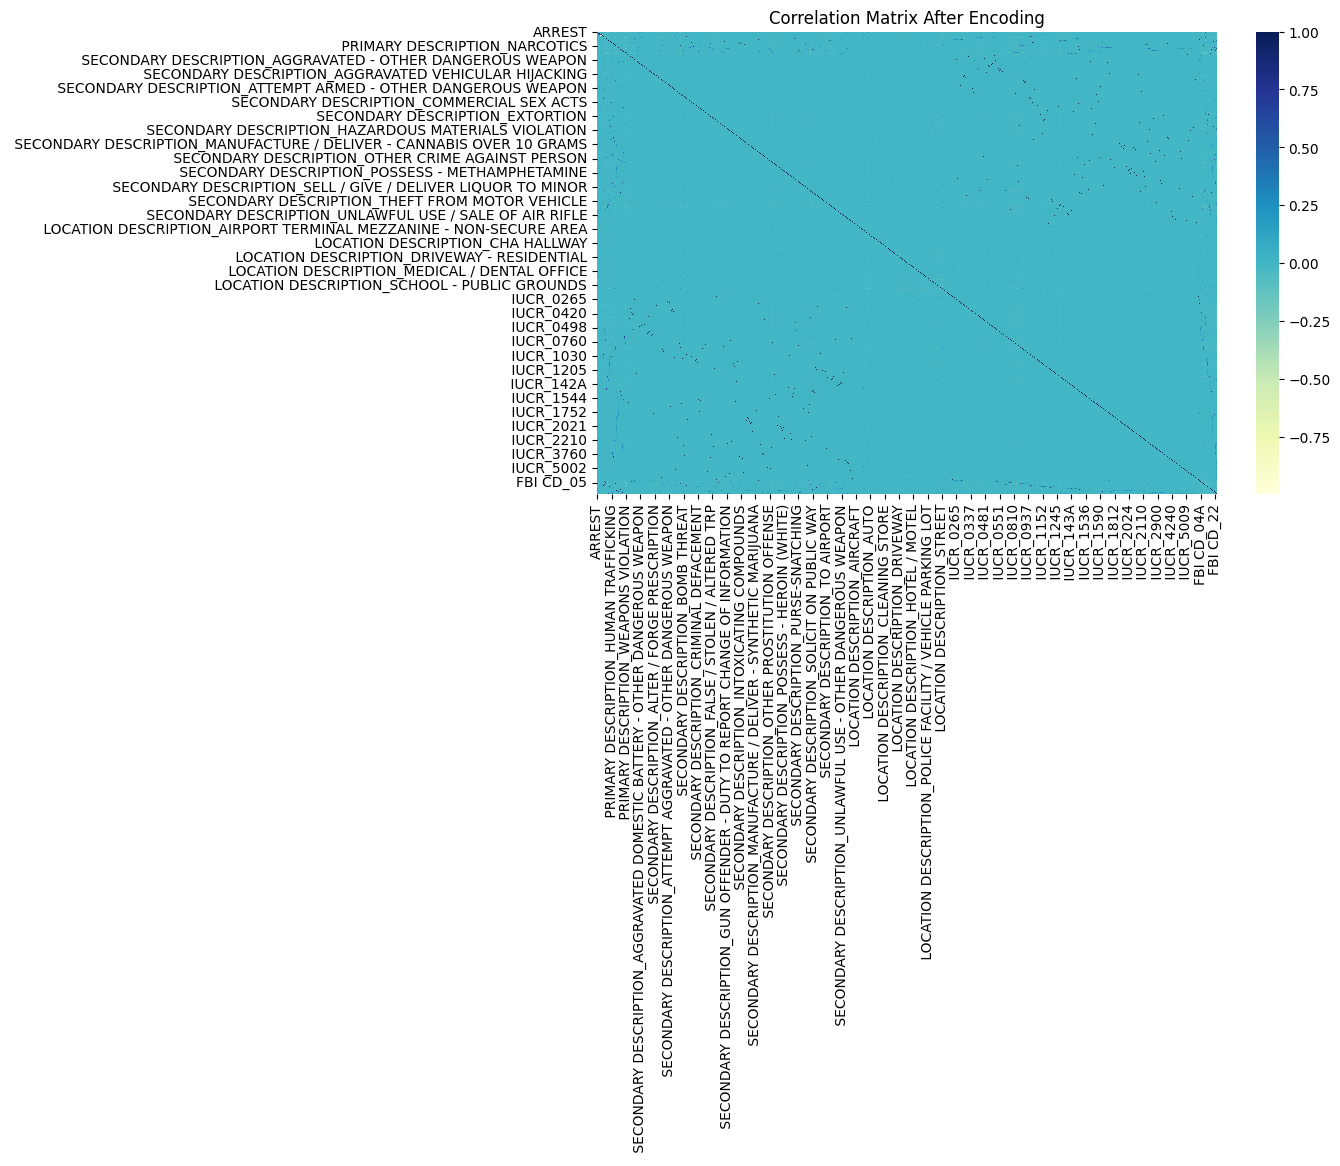

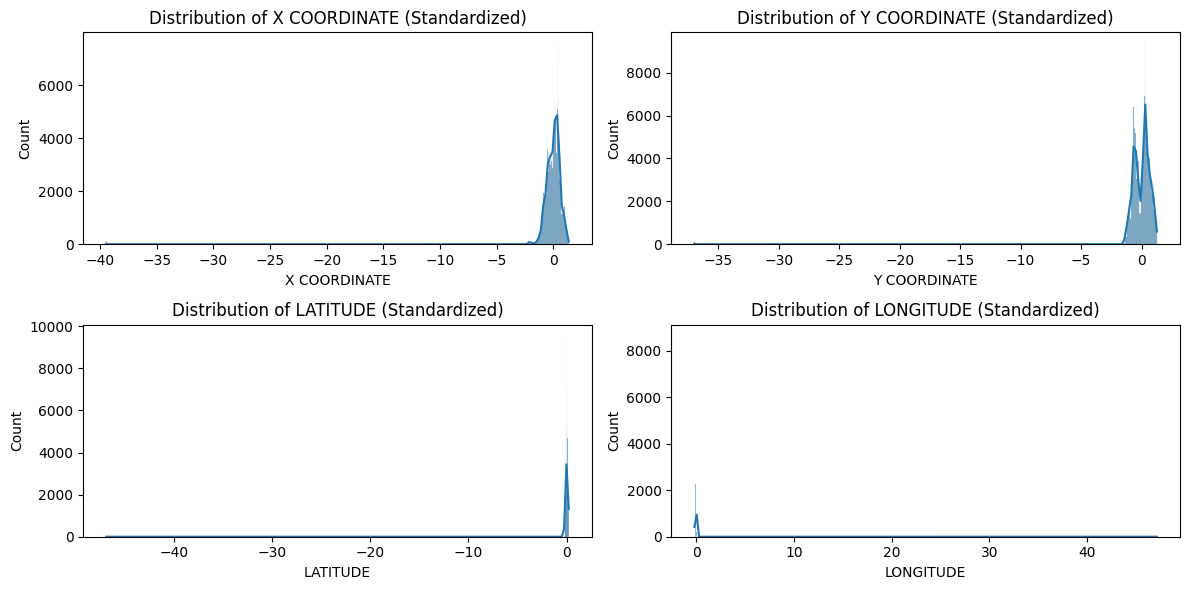

In [2]:
# Step 2: Data Preprocessing and Visualization

# 1. Initial Data Distribution (Before Encoding and Standardization)
plt.figure(figsize=(10, 6))
sns.countplot(data['ARREST'])
plt.title('Distribution of Arrests')
plt.xlabel('Arrest Made')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data[' PRIMARY DESCRIPTION'])
plt.title('Primary Crime Type Distribution')
plt.xlabel('Primary Crime Description')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Encode binary categorical columns (like ARREST and DOMESTIC)
label_encoder = LabelEncoder()
data['ARREST'] = label_encoder.fit_transform(data['ARREST'])
data['DOMESTIC'] = label_encoder.fit_transform(data['DOMESTIC'])

# Drop irrelevant columns
data = data.drop(['CASE#', 'BLOCK', 'DATE  OF OCCURRENCE', 'LOCATION'], axis=1)

# 2. One-hot encode categorical columns with more than two categories
data = pd.get_dummies(data, columns=[' PRIMARY DESCRIPTION', ' SECONDARY DESCRIPTION', ' LOCATION DESCRIPTION', ' IUCR', 'FBI CD'])

# Fill any missing values
data.fillna(0, inplace=True)

# 3. Distribution After Encoding
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=False)
plt.title('Correlation Matrix After Encoding')
plt.show()

# Standardize the numeric columns
scaler = StandardScaler()
numeric_columns = ['X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# 4. Distribution of Standardized Numeric Columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col} (Standardized)')
plt.tight_layout()
plt.show()


In [3]:
# Step 3: Define target and features
X = data.drop('ARREST', axis=1)  # Features
y = data['ARREST']               # Target

# Convert X and y to NumPy arrays
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

# Reshape X for CNN input (samples, timesteps, features)
X = np.expand_dims(X, axis=2)  # Expanding dimensions for CNN input


In [4]:
# Step 4: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**#CNN MODEL**

In [35]:
# Step 5: Build CNN model
model1 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

C:\Users\vedan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Step 6: Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [38]:
# Step 7: Train the model
history = model1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 225s 35ms/step - accuracy: 0.9103 - loss: 0.2686 - val_accuracy: 0.9170 - val_loss: 0.2390
Epoch 2/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 205s 32ms/step - accuracy: 0.9188 - loss: 0.2379 - val_accuracy: 0.9176 - val_loss: 0.2373
Epoch 3/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 237s 37ms/step - accuracy: 0.9191 - loss: 0.2342 - val_accuracy: 0.9177 - val_loss: 0.2385
Epoch 4/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 244s 38ms/step - accuracy: 0.9188 - loss: 0.2334 - val_accuracy: 0.9177 - val_loss: 0.2378
Epoch 5/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 245s 38ms/step - accuracy: 0.9192 - loss: 0.2336 - val_accuracy: 0.9177 - val_loss: 0.2374


In [40]:
# Step 8: Evaluate the model
loss, accuracy_CNN = model1.evaluate(X_test, y_test)
print(f"Test Accuracy for CNN Model: {accuracy_CNN * 100:.2f}%")


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9181 - loss: 0.2353
Test Accuracy for CNN Model: 91.76%


**#RNN MODEL**

In [47]:
# Build RNN model
model2 = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\vedan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model2.fit(
    X_train, y_train,
    epochs=10,               # Set a reasonable number of epochs
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 3117s 483ms/step - accuracy: 0.8723 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 2/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 2738s 425ms/step - accuracy: 0.8727 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 3/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 2791s 433ms/step - accuracy: 0.8733 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 4/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 2804s 435ms/step - accuracy: 0.8729 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 5/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 2839s 440ms/step - accuracy: 0.8731 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 6/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 2848s 442ms/step - accuracy: 0.8738 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 7/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 2856s 443ms/step - accuracy: 0.8742 - loss: nan - val_accuracy: 0.8730 - val_loss: nan
Epoch 8/10
6448/6448 ━━━━━━━━━━━━━━━━━━━━ 14413s 2s/step - accuracy: 0.8723 - loss: nan - val_acc

In [ ]:
# Step 8: Evaluate the model
loss, accuracy_RNN = model2.evaluate(X_test, y_test)
print(f"Test Accuracy for RNN Model: {accuracy_RNN * 100:.2f}%")


**#Multi-Layer Perceptron (MLP)**

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the MLP model
model3 = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Adjust activation for multi-class classification if needed
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8548 - loss: 0.9036 - val_accuracy: 0.9135 - val_loss: 0.2510
Epoch 2/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9032 - loss: 0.2807 - val_accuracy: 0.9136 - val_loss: 0.2612
Epoch 3/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9077 - loss: 0.2721 - val_accuracy: 0.9180 - val_loss: 0.2455
Epoch 4/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9106 - loss: 0.2618 - val_accuracy: 0.9076 - val_loss: 0.2603
Epoch 5/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9091 - loss: 0.2613 - val_accuracy: 0.9169 - val_loss: 0.2438
Epoch 6/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9138 - loss: 0.2538 - val_accuracy: 0.9152 - val_loss: 0.2550
Epoch 7/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9137 - loss: 0.2511 - val_accuracy: 0.9165 - val_loss: 0.2518
Epoch 8/50
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9152 - loss: 0.24

In [44]:
# Step 8: Evaluate the model
loss, accuracy_MLP = model3.evaluate(X_test, y_test)
print(f"Test Accuracy for MLP Model: {accuracy_MLP * 100:.2f}%")


1612/1612 ━━━━━━━━━━━━━━━━━━━━ 2s 973us/step - accuracy: 0.9161 - loss: 0.2457
Test Accuracy for MLP Model: 91.52%


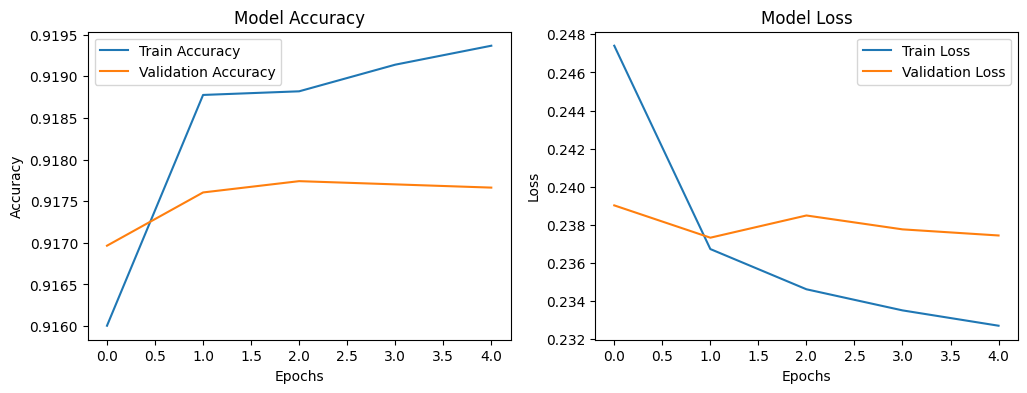

In [45]:
# Step 9: Plot accuracy and loss curves (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()